# Pretrained model in WrappedDinoV2

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/19 20:42:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/19 20:42:49 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
# get dataframes
gcs_path = "gs://dsgt-clef-plantclef-2024"
data_path = "data/parquet_files/PlantCLEF2024_training_cropped_resized_v2"

# paths to dataframe
train_path = f"{gcs_path}/{data_path}"
# read data
train_df = spark.read.parquet(train_path)
# show
train_df.show(n=5, truncate=50)

+--------------------------------------------+--------------------------------------------------+------+----------+----------+----------------------------------------------+-------+-------------------------------------+--------+-------------+-------------+---------------+--------------------------------------+----------+-------------+--------+-----------+--------------------------------------------------+--------------------------------------------------+---------+--------------------------------------------------+--------------------------------------------------+
|                                  image_name|                                              path| organ|species_id|    obs_id|                                       license|partner|                               author|altitude|     latitude|    longitude|gbif_species_id|                               species|     genus|       family| dataset|  publisher|                                        references|                    

In [4]:
limit_df = train_df.orderBy("image_name").limit(10).cache()
limit_df.count()

10

In [5]:
import io

import numpy as np
import pandas as pd
import timm
import torch
from PIL import Image
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, FloatType
from pyspark.ml import Transformer
from pyspark.ml.functions import predict_batch_udf
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from plantclef.model_setup import setup_pretrained_model
from pyspark.sql import DataFrame
from pyspark.ml.functions import vector_to_array
from pyspark.ml import Pipeline
from pyspark.ml.feature import SQLTransformer

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
class WrappedPretrainedDinoV2(
    Transformer,
    HasInputCol,
    HasOutputCol,
    DefaultParamsReadable,
    DefaultParamsWritable,
):
    """
    Wrapper for DinoV2 to add it to the pipeline
    """

    def __init__(
        self,
        pretrained_path: str,
        input_col: str = "input",
        output_col: str = "output",
        model_name: str = "vit_base_patch14_reg4_dinov2.lvd142m",
        batch_size: int = 8,
    ):
        super().__init__()
        self._setDefault(inputCol=input_col, outputCol=output_col)
        self.pretrained_path = pretrained_path
        self.model_name = model_name
        self.batch_size = batch_size
        self.num_classes = 7806  # total number of plant species
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.sql_statement = "SELECT image_name, cls_embedding FROM __THIS__"
        self.model = timm.create_model(
            self.model_name,
            pretrained=False,
            num_classes=self.num_classes,
            checkpoint_path=self.pretrained_path,
        )
        # Data transform
        self.data_config = timm.data.resolve_model_data_config(self.model)
        self.transforms = timm.data.create_transform(
            **self.data_config, is_training=False
        )
        # Move model to GPU if available
        self.model.to(self.device)

    def _make_predict_fn(self):
        """Return PredictBatchFunction using a closure over the model"""

        def predict(inputs: np.ndarray) -> np.ndarray:
            images = [Image.open(io.BytesIO(input)) for input in inputs]
            model_inputs = torch.stack(
                [self.transforms(img).to(self.device) for img in images]
            )

            with torch.no_grad():
                features = self.model.forward_features(model_inputs)
                cls_token = features[:, 0, :]

            numpy_array = cls_token.cpu().numpy()
            return numpy_array

        return predict

    def _transform(self, df: DataFrame):
        return df.withColumn(
            self.getOutputCol(),
            predict_batch_udf(
                make_predict_fn=self._make_predict_fn,
                return_type=ArrayType(FloatType()),
                batch_size=self.batch_size,
            )(self.getInputCol()),
        )

    def transform(self, df) -> DataFrame:
        transformed = self._transform(df)

        for c in self.feature_columns:
            # check if the feature is a vector and convert it to an array
            if "array" in transformed.schema[c].simpleString():
                continue
            transformed = transformed.withColumn(c, vector_to_array(F.col(c)))
        return transformed

    @property
    def feature_columns(self) -> list:
        return ["cls_embedding"]

    def pipeline(self):
        return Pipeline(stages=[self, SQLTransformer(statement=self.sql_statement)])

    def run(self, df: DataFrame) -> DataFrame:
        model = self.pipeline().fit(df)
        transformed = model.transform(df)

        return transformed

In [7]:
# choose pretrained model
use_only_classifier = True
# model setup
pretrained_path = setup_pretrained_model(use_only_classifier)
pretrained_dino = WrappedPretrainedDinoV2(
    pretrained_path=pretrained_path,
    input_col="data",
    output_col="cls_embedding",
)

Model already exists. Skipping download and extraction.


In [8]:
transformed_df = pretrained_dino.run(df=limit_df).cache()
transformed_df.show(n=5, truncate=50)

+--------------------------------------------+--------------------------------------------------+
|                                  image_name|                                     cls_embedding|
+--------------------------------------------+--------------------------------------------------+
|00002431a327bc86b2aa2c53bb8d98b971c58a63.jpg|[-0.5283968, 0.019686425, -0.97897506, -0.94771...|
|0000253037afde30e78a8a62c8b79575ffcf899f.jpg|[-1.7891474, 1.3825662, -0.5581362, -0.07554579...|
|00002a043feec3933eae637c56cc9d2eaf102fac.jpg|[0.14106934, 1.3774437, -1.4869304, 0.4459311, ...|
|00002eea34490fb467b5455765e799f20e54f571.jpg|[-0.79407436, 1.5959152, -0.26652727, -0.044507...|
|000033d0688ee9935b5260e0886a9b59384143f7.jpg|[-0.35794804, 1.1341614, 0.986612, -1.3796183, ...|
+--------------------------------------------+--------------------------------------------------+
only showing top 5 rows



### check embeddings created

In [9]:
# get dataframes
gcs_path = "gs://dsgt-clef-plantclef-2024/data/process/training_cropped_resized_v2"
cls_data_path = "dino_cls_token/data"
pre_data_path = "dino_pretrained/data"

# paths to dataframe
cls_path = f"{gcs_path}/{cls_data_path}"
pre_path = f"{gcs_path}/{pre_data_path}"
# read data
cls_df = spark.read.parquet(cls_path)
pre_df = spark.read.parquet(pre_path)
# show
cls_df.show(n=5, truncate=50)
pre_df.show(n=5, truncate=50)

+--------------------------------------------+----------+--------------------------------------------------+
|                                  image_name|species_id|                                     cls_embedding|
+--------------------------------------------+----------+--------------------------------------------------+
|5ddad155a99ff9b22355b940c100ee588fd73587.jpg|   1390691|[1.2776474, 1.4595255, 1.7950346, 2.156743, 2.8...|
|ea74d65858ceb7d55981560684234b826a7645e2.jpg|   1360260|[-1.9118708, 3.0542357, -3.143496, 1.4037858, 0...|
|86eb8b2e1a7b6a6d4bdd7b49a1e4bd090b867cf5.jpg|   1390699|[0.57074785, 1.7904518, -1.0096772, 1.4558841, ...|
|4dd8c6a10041b1c028823d667316679da4c457fd.jpg|   1396486|[0.85863805, -2.9571414, 1.3469055, -0.8254508,...|
|1d5d139f575031bd13940c1ef10bf4e73dac6d41.jpg|   1356608|[-0.4914153, -1.3314899, 0.33835393, -0.6760831...|
+--------------------------------------------+----------+--------------------------------------------------+
only showing top 5 

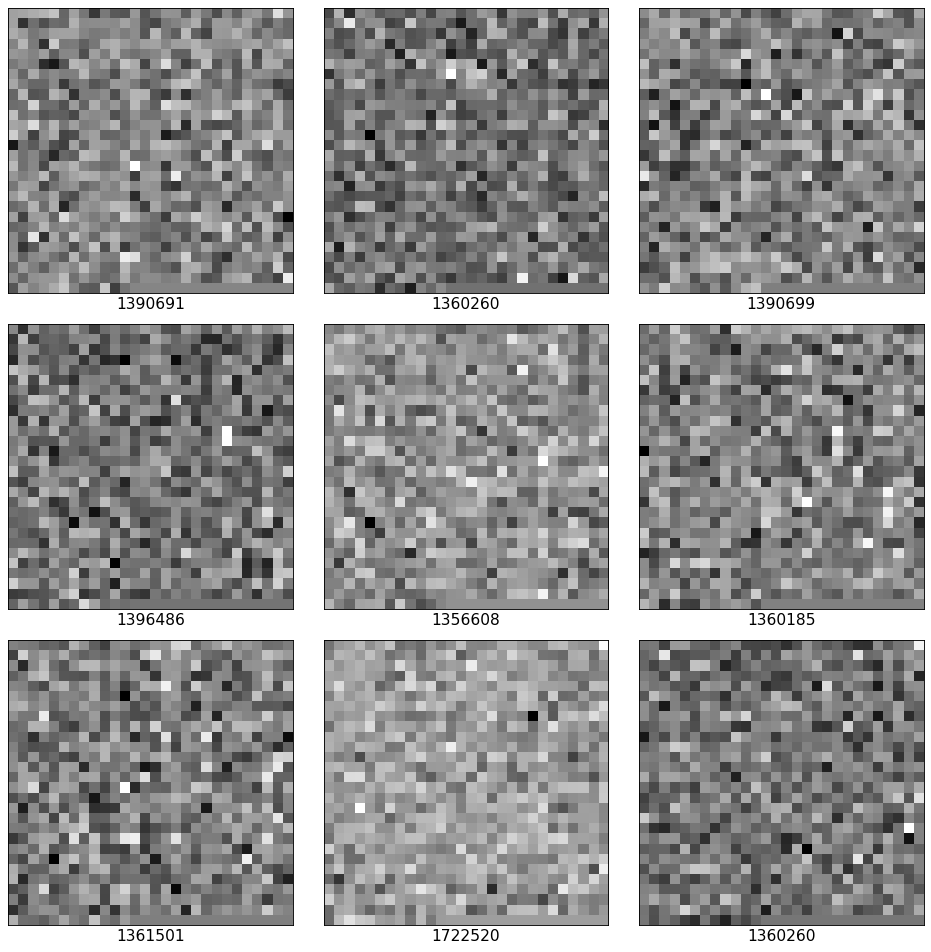

In [10]:
from plantclef.plotting import plot_images_from_embeddings

# Plot test DINO image embeddings
plot_images_from_embeddings(
    cls_df, data_col="cls_embedding", image_col="species_id", grid_size=(3, 3)
)

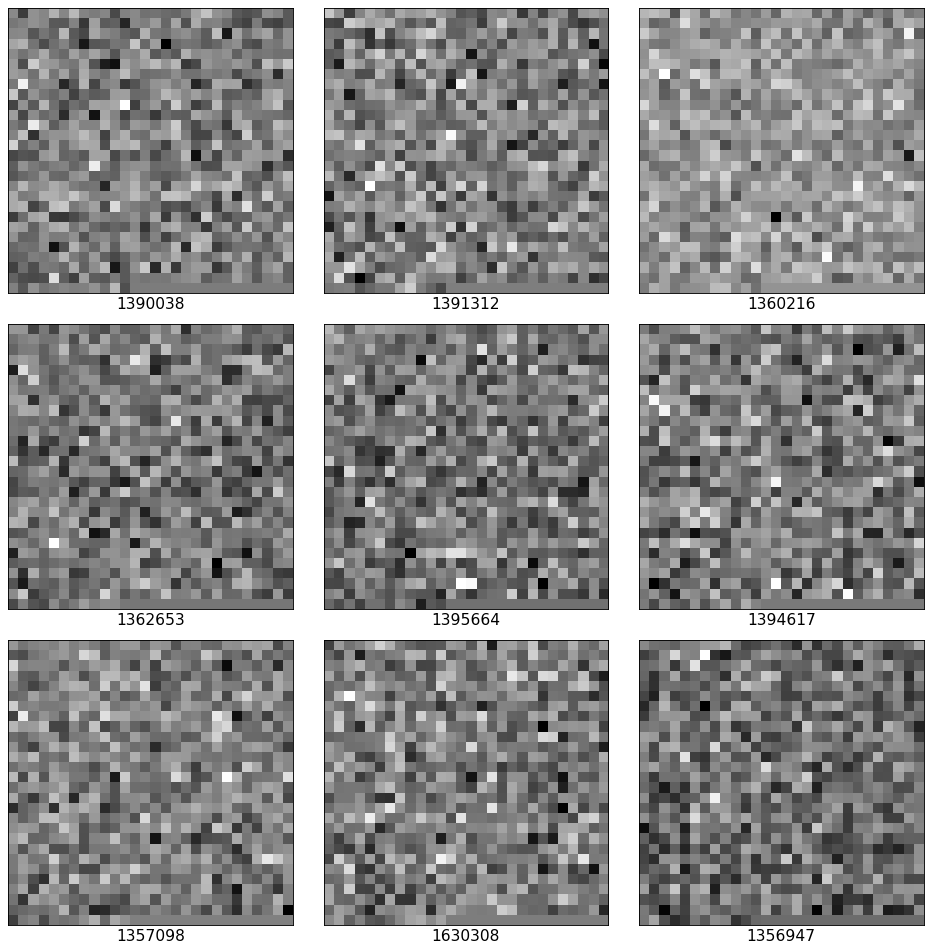

In [11]:
# Plot test DINO image embeddings
plot_images_from_embeddings(
    pre_df, data_col="cls_embedding", image_col="species_id", grid_size=(3, 3)
)

In [12]:
cls_row = cls_df.select("cls_embedding").first()
pre_row = pre_df.select("cls_embedding").first()
# print
print(f"dino cls count: {len(cls_row['cls_embedding'])}")
print(f"pretrained cls count: {len(pre_row['cls_embedding'])}")

dino cls count: 768
pretrained cls count: 768


start: 8:33:06pm
finish: 4:41:35pm